# Set up

In [1]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [2]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [3]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [4]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd = pickle.load(file)

In [5]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# Inputs of modalities

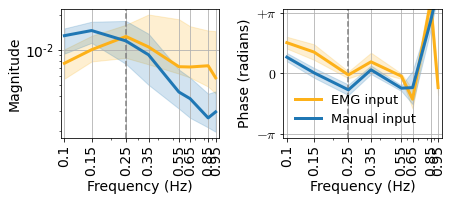

In [12]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

cond = 2
fig,axs = plt.subplots(1,2,sharex=True,figsize=(6.5,3))

# magnitude
ax = axs[0]
ax.axvline(x=0.25, color='grey', linestyle='--')
U0_mean = np.mean(np.abs(U0s[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

U1_mean = np.mean(np.abs(U1s[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
ax.plot(freqs,q50,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency (Hz)')

# phase
ax = axs[1]
ax.axvline(x=0.25, color='grey', linestyle='--')
angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = 'EMG input',color = colors['GOLD'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,:,:][:,:,IX]))),axis = 1))
z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
mean = np.angle(z)+np.pi/2
disp = 1 - np.abs(z)
ax.plot(freqs,mean,'-',label = 'Manual input',color = colors['BLUE'],linewidth = 3)
ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

ax.set_ylabel('Phase (radians)') 
ax.grid('on',zorder=-1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('Frequency (Hz)')
ax.legend(loc = 'lower left',frameon=False, fontsize = 13)
# axs[0].legend(bbox_to_anchor=(1., 1.3),frameon=False, ncol = 2)
plt.tight_layout()
# fig.savefig('multimodal_inputs.svg')
plt.show()

# Feedforward and Feedback

In [7]:
def FF_FB(Tur,Tud):
    B = - (1 / M) * (Tud / (1+ Tud)) 
    F = (1 + B * M)*Tur - B
    return F,B
def FF_FB_each_modality(Tu0r,Tu0d,Tu1r,Tu1d,w): #w = weighting of EMG
    w0 = w
    w1 = 1-w
    B0 = (- (1/M) * Tu0d) / (1 + w0*Tu0d + w1*Tu1d)
    B1 = (- (1/M) * Tu1d) / (1 + w0*Tu0d + w1*Tu1d)
    F0 = -B0 + Tu0r + w0 * B0 * M * Tu0r + w1 * B0 * M * Tu1r
    F1 = -B1 + Tu1r + w0 * B1 * M * Tu0r + w1 * B1 * M * Tu1r
    return F0,F1,B0,B1

F = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for i in range(trial_num//2):
            F[sub,cond,i],B[sub,cond,i] = FF_FB(Tur[sub,cond,i],Tud[sub,cond,i])
print(F.shape) # subject x condition x trial//2 x stimulated freqs
print(B.shape)

F0 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
F1 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B0 = np.zeros(Tur.shape, dtype=complex)
B1 = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        w = alphas[cond]
        for i in range(trial_num//2):
            F0[sub,cond,i],F1[sub,cond,i],B0[sub,cond,i],B1[sub,cond,i] \
                = FF_FB_each_modality(Tu0r[sub,cond,i],Tu0d[sub,cond,i],Tu1r[sub,cond,i],Tu1d[sub,cond,i],w)
print(F0.shape) # subject x condition x trial//2 x stimulated freqs
print(B0.shape)

(15, 5, 7, 8)
(15, 5, 7, 8)
(15, 5, 7, 8)
(15, 5, 7, 8)


# Individaul strategies

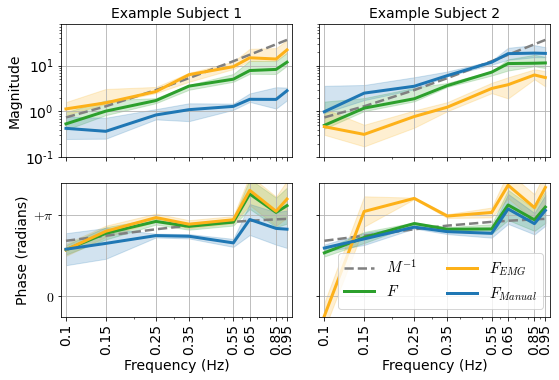

In [8]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi/4, np.pi+1.2)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
cond = 2

fig,axs = plt.subplots(2,2,sharex = 'col', sharey = 'row',figsize=(8,5.5))

for i,sub in enumerate([10,6]):
    # magnitude
    ax = axs[0,i]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
    
    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F0[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

    mean, q25,q50,q75 = mean_and_interquartile(np.abs(F1[sub,cond,:,:]), axis = 0) #across all trials
    ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    
    # phase
    ax = axs[1,i]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

    angle = np.mean(np.exp(1j*(np.angle(F[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F$',color = colors['GREEN'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

    angle = np.mean(np.exp(1j*(np.angle(F0[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angle = np.mean(np.exp(1j*(np.angle(F1[sub,cond,:,:])-np.pi/2)),axis = 0)
    mean = np.angle(angle)+np.pi/2
    disp = 1 - np.abs(angle)
    ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('Frequency (Hz)')

axs[1,0].set_xticks(xticks)
axs[1,0].set_xticklabels(xticks,rotation=90) 
axs[1,1].set_xticks(xticks)
axs[1,1].set_xticklabels(xticks,rotation=90) 
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase (radians)')
axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
# axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 12)
axs[0,0].set_title('Example Subject 1',fontsize = 14)
axs[0,1].set_title('Example Subject 2',fontsize = 14)
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
plt.tight_layout()
fig.savefig('example_subjects.svg')
plt.show()

## individual performance (time domain)

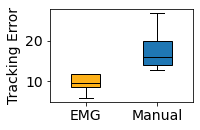

In [9]:
labels = ['EMG','Manual'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]

sub = 10 # example subject 1
avg_error_slider = errors[sub,0,-4:] # slider only condition, last 4 trials
avg_error_emg = errors[sub,4,-4:] # emg only condition, last 4 trials
datas = [avg_error_emg,avg_error_slider]
# yticks = [0.,50,100]

fig,ax = plt.subplots(figsize=(3,2))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
# ax.set_ylim(0,100) # set y axis limit
# ax.set_yticks(yticks) #set y axis ticks
# ax.set_title('Example Subject 1',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.tight_layout()
fig.savefig('example_sub1.svg')
plt.show()

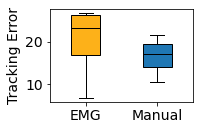

In [10]:
labels = ['EMG','Manual'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]

sub = 6 # example subject 1
avg_error_slider = errors[sub,0,-4:] # slider only condition, last 4 trials
avg_error_emg = errors[sub,4,-4:] # emg only condition, last 4 trials 
datas = [avg_error_emg,avg_error_slider]
# yticks = [0.,50,100]

fig,ax = plt.subplots(figsize=(3,2))
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
# ax.set_xlabel(r'$\alpha$',fontsize = 14) #add x axis labels
# ax.set_ylim(0,100) # set y axis limit
# ax.set_yticks(yticks) #set y axis ticks
# ax.set_title('Example Subject 2',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.tight_layout()
fig.savefig('example_sub2.svg')
plt.show()

# Group people's better modality

In [64]:
avg_errors_slider = np.mean(errors[:,0,-4:],axis = 1) # slider only condition, last 4 trials
avg_errors_emg = np.mean(errors[:,4,-4:],axis = 1) # emg only condition, last 4 trials 
avg_errors_slider,avg_errors_emg

(array([ 24.61358698,  74.67738171,  39.14504844,  41.79853006,
         98.83679008,  12.38954531,  16.54242273,  33.30467105,
         19.63313128,  44.64789093,  17.87806994,  38.7626948 ,
         19.213824  , 101.5626955 ,  40.17109438]),
 array([ 20.38982803, 633.14936659,  27.43209348,  18.60563704,
        177.14268977,   8.71005092,  19.9220363 ,  32.73341267,
          6.50489251, 104.83528429,  10.86552922,  14.78921974,
         14.43955604,  29.9748155 ,   9.30384281]))

In [83]:
avg_errors_emg - avg_errors_slider

array([ -4.22375895, 558.47198488, -11.71295495, -23.19289301,
        78.30589969,  -3.67949439,   3.37961357,  -0.57125838,
       -13.12823878,  60.18739336,  -7.01254072, -23.97347506,
        -4.77426795, -71.58788001, -30.86725157])

In [104]:
# find who is better at which modality
slider_experts = []
emg_experts = []
both_experts = []
for sub in range(subject_num):
    diff = avg_errors_emg[sub] - avg_errors_slider[sub]
    if diff > 0 and np.abs(diff) > 4:
        slider_experts.append(sub)
    elif diff < 0 and np.abs(diff) > 4:
        emg_experts.append(sub)
    else:
        both_experts.append(sub)
slider_experts = np.array(slider_experts)
emg_experts = np.array(emg_experts)
both_experts = np.array(both_experts)
# slider_experts = np.argsort(avg_errors_slider)[:5]
# emg_experts = np.argsort(avg_errors_emg)[:5]
slider_experts_num = len(slider_experts)
emg_experts_num = len(emg_experts)
both_experts_num = len(both_experts)    
print('slider experts = ',slider_experts)
print('emg experts = ',emg_experts)
print('both experts = ',both_experts)

slider experts =  [1 4 9]
emg experts =  [ 0  2  3  8 10 11 12 13 14]
both experts =  [5 6 7]


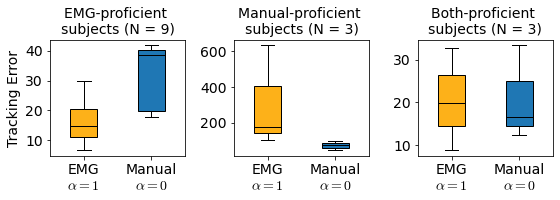

In [110]:
labels = ['EMG''\n'r'$\alpha = 1$','Manual''\n'r'$\alpha = 0$'] #slider : EMG
boxcolors = [colors['GOLD'],colors['BLUE']]
last_few_trials = 4

fig,axs= plt.subplots(1,3,figsize=(8,3))
ax = axs[0]
slider = np.mean(errors[emg_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[emg_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14) # add title
ax.set_ylabel('Tracking Error',fontsize = 14) # add y axis label

ax = axs[1]
slider = np.mean(errors[slider_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[slider_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)

ax = axs[2]
slider = np.mean(errors[both_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[both_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
datas = [emg,slider]
bplot = ax.boxplot(datas, widths = 0.4,patch_artist=True,labels=labels, showfliers=False)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')
ax.set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14) # add title
plt.tight_layout()
# fig.savefig('example_sub2.svg')
plt.show()

## F0 and F1 of them

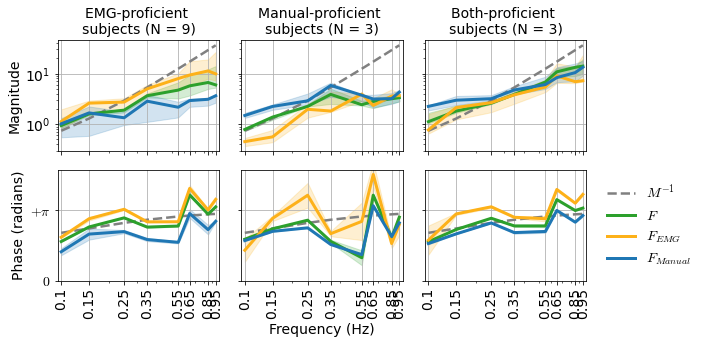

In [147]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 7 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

    for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
        
        mean = np.mean(np.abs(F[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        
        # phase
        ax = axs[1,i]
        ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F$',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

        ax.grid('on',zorder=-1)
        ax.set_ylim(ylimphase)
        ax.set_yticks(yticksphase)
        ax.set_yticklabels(yticklabelsphase)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,rotation=90) 
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Magnitude')
    axs[1,0].set_ylabel('Phase (radians)')
    # axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
    axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
    axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
    axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
    axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    # fig.savefig('example_subjects.svg')
    plt.show()

In [127]:
F0[sub,cond,-last_few_trials:,:].shape

(3, 7, 8)

In [129]:
# sub = emg_experts
last_few_trials = 7 # cross trials (N//2)

for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        data = [np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = (1,2)),
                np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = (1,2))] #mean across trials
        data = np.array(data)
        print(WilcoxonTest(data))

(array([nan,  5.,  5., nan]), array([      nan, 0.0390625, 0.0390625,       nan]), array([nan,  1.,  1., nan]), ['there is significant difference between condition 0 and condition 1, w = 5.0, pvalue = 0.0390625'])
(array([nan,  3.,  3., nan]), array([nan,  1.,  1., nan]), array([nan,  0.,  0., nan]), [])
(array([nan,  3.,  3., nan]), array([nan,  1.,  1., nan]), array([nan,  0.,  0., nan]), [])


In [137]:
# EMG / manual
slider = np.mean(errors[slider_experts,0,-last_few_trials:],axis = 1) # slider only condition, last 4 trials
emg = np.mean(errors[slider_experts,4,-last_few_trials:],axis = 1) # emg only condition, last 4 trials 
np.mean(emg)/np.mean(slider)

4.194713458589944

In [144]:
cond = 2
sub = slider_experts
mean_emg = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
mean_slider = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
np.mean(mean_emg)/np.mean(mean_slider)

0.6657286904336085

## B0 and B1

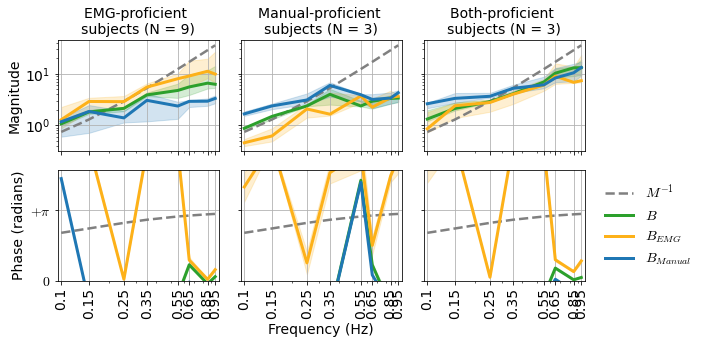

In [148]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']
last_few_trials = 7 # cross trials (N//2)

for cond in [2]:
    fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

    for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
        # magnitude
        ax = axs[0,i]
        ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
        
        mean = np.mean(np.abs(B[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (combined)',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GREEN'])

        mean = np.mean(np.abs(B0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])

        mean = np.mean(np.abs(B1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
        q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
        ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.grid('on',zorder=-1)
        # ax.set_ylim(0.1,80)
        ax.set_yscale("log")
        
        # phase
        ax = axs[1,i]
        ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B$',color = colors['GREEN'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GREEN'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B_{EMG}$',color = colors['GOLD'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

        angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
        z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
        mean = np.angle(z)+np.pi/2
        disp = 1 - np.abs(z)
        ax.plot(freqs,mean,'-',label = r'$B_{Manual}$',color = colors['BLUE'],linewidth = 3)
        ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

        ax.grid('on',zorder=-1)
        ax.set_ylim(ylimphase)
        ax.set_yticks(yticksphase)
        ax.set_yticklabels(yticklabelsphase)

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks,rotation=90) 
    axs[1,1].set_xlabel('Frequency (Hz)')
    axs[0,0].set_ylabel('Magnitude')
    axs[1,0].set_ylabel('Phase (radians)')
    # axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
    axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
    axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
    axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
    axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
    axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
    axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

    plt.tight_layout()
    # fig.savefig('example_subjects.svg')
    plt.show()

## F0 of emg-experts in emg-only

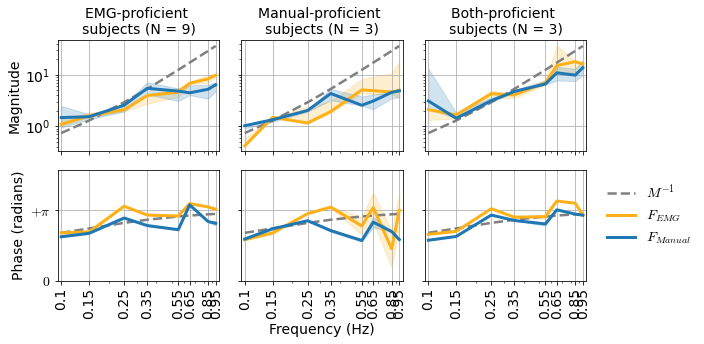

In [134]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1.8)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']
TFlabels = ['F','B','F0','F1','B0','B1']

last_few_trials = 4 # cross trials (N//2)

fig,axs = plt.subplots(2,3,sharex = 'col', sharey = 'row',figsize=(10,5))

for i,sub in enumerate([emg_experts,slider_experts,both_experts]):
    # magnitude
    ax = axs[0,i]
    ax.plot(freqs,np.abs(1/M),'--',color= 'grey',label = r'Machine inverse $M^{-1}$',linewidth = 2.5)
    
    cond = 4 # emg-only
    mean = np.mean(np.abs(F0[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
    ax.plot(freqs,q50,'-',label = 'Feedforward (EMG pathway)',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['GOLD'])
    
    cond = 0 # slider-only
    mean = np.mean(np.abs(F1[sub,cond,-last_few_trials:,:]),axis = 1) #mean across trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) #across subjects
    ax.plot(freqs,q50,'-',label = 'Feedforward (Manual pathway)',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs, q25, q75, alpha=0.2, color=colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    
    # phase
    ax = axs[1,i]
    ax.plot(freqs,np.angle(1/M),'--',color= 'grey',label = r'$M^{-1}$',linewidth = 2.5)

    cond = 4 # emg-only
    angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
    z = np.mean(np.exp(1j*(angle-np.pi)), axis=0) #mean across subjects
    mean = np.angle(z)+np.pi
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$F_{EMG}$',color = colors['GOLD'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    cond = 0 # slider-only
    angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[sub,cond,-last_few_trials:,:]))),axis = 1)) #mean across trials
    z = np.mean(np.exp(1j*(angle-np.pi/2)), axis=0) #mean across subjects
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-',label = r'$F_{Manual}$',color = colors['BLUE'],linewidth = 3)
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
axs[1,1].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Magnitude')
axs[1,0].set_ylabel('Phase (radians)')
# axs[1,1].legend(loc='lower right', ncol = 2,fontsize = 15)
axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False,fontsize = 14)
axs[0,0].set_title('EMG-proficient ''\n''subjects (N = '+str(emg_experts_num)+')',fontsize = 14)
axs[0,1].set_title('Manual-proficient ''\n''subjects (N = '+str(slider_experts_num)+')',fontsize = 14)
axs[0,2].set_title('Both-proficient ''\n''subjects (N = '+str(both_experts_num)+')',fontsize = 14)
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
axs[0,2].get_shared_x_axes().join(axs[0,0], axs[0,1])

plt.tight_layout()
# fig.savefig('example_subjects.svg')
plt.show()

# difference in perfromance 

In [71]:
avg_errors_slider = np.mean(errors[:,0,-4:],axis = 1) # slider only condition, last 4 trials
avg_errors_emg = np.mean(errors[:,4,-4:],axis = 1) # emg only condition, last 4 trials 
avg_errors_slider,avg_errors_emg

(array([ 24.61358698,  74.67738171,  39.14504844,  41.79853006,
         98.83679008,  12.38954531,  16.54242273,  33.30467105,
         19.63313128,  44.64789093,  17.87806994,  38.7626948 ,
         19.213824  , 101.5626955 ,  40.17109438]),
 array([ 20.38982803, 633.14936659,  27.43209348,  18.60563704,
        177.14268977,   8.71005092,  19.9220363 ,  32.73341267,
          6.50489251, 104.83528429,  10.86552922,  14.78921974,
         14.43955604,  29.9748155 ,   9.30384281]))

In [72]:
# see if the difference in tracking error corrosponds to difference in F0 and F1
error_diff = avg_errors_emg - avg_errors_slider
error_diff 

array([ -4.22375895, 558.47198488, -11.71295495, -23.19289301,
        78.30589969,  -3.67949439,   3.37961357,  -0.57125838,
       -13.12823878,  60.18739336,  -7.01254072, -23.97347506,
        -4.77426795, -71.58788001, -30.86725157])

In [80]:
# difference in F0 and F1
cond = 2
last_few_trials = 7 # cross all trials (N//2)


avg_F0 = np.mean(np.abs(F0[:,cond,-last_few_trials:,:]),axis = 1) #mean across trials
avg_F1 = np.mean(np.abs(F1[:,cond,-last_few_trials:,:]),axis = 1) #mean across trials
diff_F = avg_F0 - avg_F1
diff_F.shape

(15, 8)

# UCM at stim freqs

In [ ]:
# r? 

c:\Users\amber\anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


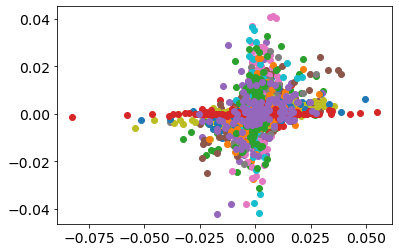

In [156]:
cond = 2
for sub in range(subject_num):
    plt.scatter(U0s[sub,cond,:,:][:,IX],U1s[sub,cond,:,:][:,IX])

In [157]:
nonstim_freqs = np.delete(xf, IX)
U0Xs = np.delete(U0s[:,:,:,:N//2], IX,axis = 3)
U1Xs = np.delete(U1s[:,:,:,:N//2], IX,axis = 3)
U0Xs.shape

(15, 5, 14, 1192)

c:\Users\amber\anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


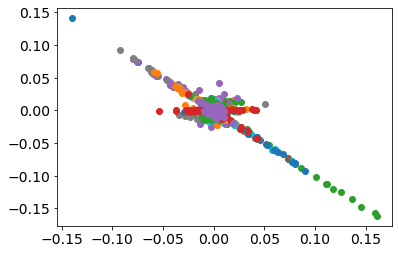

In [158]:
cond = 2
for sub in range(subject_num):
    plt.scatter(U0Xs[sub,cond,:,:],U1Xs[sub,cond,:,:])

c:\Users\amber\anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


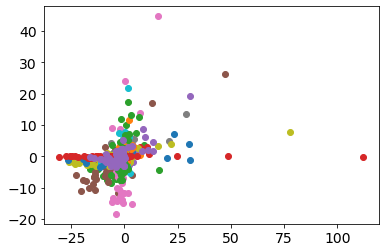

In [154]:
cond = 2
for sub in range(subject_num):
    plt.scatter(F0[sub,cond,:,:],F1[sub,cond,:,:])